In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Run inference on CPU

In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re

import h5py
from scipy.ndimage import zoom

from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
#import display_fns

import automap_fns
import unrolling_fns

2024-11-14 15:13:36.947749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 15:13:37.649992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
plt.rc('font', size=9)

## Importing fastMRI data and downsampling

The downsampled FastMRI data was saved externally to save processing time, it can be regenerated by uncommenting the following block of code

In [4]:
# loading previously downsampled fast MRI data
#inputfile = 'data/fastmri_75_64_25_train_1.npz'
inputfile = 'data/fastmri/fastmri_75_64_25_val_all.npz'
data = np.load(inputfile)

In [5]:
ksp_fs_sc_all = data['ksp_fs_sc_all']
ksp_us_sc_all = data['ksp_us_sc_all']
img_gt_sc_all = data['img_gt_sc_all']

In [6]:
ksp_fs_sc_all.shape

(1, 75, 64, 25, 1378)

In [7]:
img_gt_sc_all.shape

(75, 64, 25, 1378)

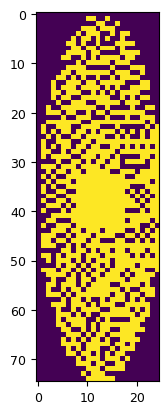

In [8]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=2
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

fig=plt.figure()
plt.imshow((abs(mask)))

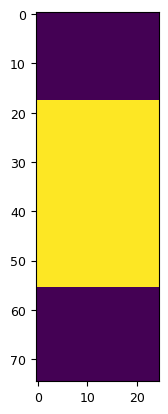

In [9]:
mask_sq = np.zeros(mask.shape)
crop_no_pe1 = 19
crop_no_pe2 = 1
mask_sq[crop_no_pe1-1:-crop_no_pe1,:]=1
fig=plt.figure()
plt.imshow((abs(mask_sq)))

1.934984520123839


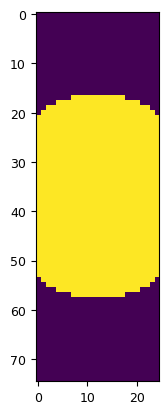

In [10]:
x_c = 37
y_c = 12

r=20.8

mask_circ = np.zeros(mask.shape)
for j in range(mask.shape[0]):
    for k in range(mask.shape[1]):
        if r > np.sqrt((j-x_c)**2+(k-y_c)**2):
            mask_circ[j,k]=1

fig=plt.figure()
plt.imshow((abs(mask_circ)))

print(1/np.mean(abs(mask_circ))) #true R value

In [11]:
#noise_dB = np.arange(50,100,2)
#n_ex_cs = 10
#n_ex_test=100

noise_dB = np.array([50,60,70,80,90])
noise_dB_zero = noise_dB - 40

#noise_dB = np.arange(50,95,2.5)
snr_val = 100.0*np.power(10.0,(noise_dB-80.0)/20.0)

n_ex_cs = 1
#n_ex_cs = 10

n_ex_test = 3
#n_ex_test = 100

In [12]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
lamda_opt_vals_sq = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals_sq = np.zeros((noise_dB.size,n_ex_cs))

In [13]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
        volumeGTscaled = img_gt_sc_all[:,:,:,k]
        
        kspInput = awgn(kspTestScaled,noise_val+3,L=1)
        uskspace = applyMask(kspInput,mask)

        lamda_opt_vals[j,k] = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
        iter_opt_vals[j,k] = find_iter_mask(uskspace,volumeGTscaled, lamda_opt_vals[j,k], mps, show_plot=False)

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in cast
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')


In [14]:
nrmse_cs_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_3dB_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_sq_vals = np.zeros((noise_dB.size,n_ex_test))

ssim_cs_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_3dB_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_sq_vals = np.zeros((noise_dB.size,n_ex_test))

In [15]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k+n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:,:,:,k+n_ex_cs]


        #PD
        
        kspInput = awgn(kspTestScaled,noise_val+3,L=1)
        uskspace = applyMask(kspInput,mask)

    
        volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
        volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        volcsrecon = ulfl1recon(uskspace,mask,lamda_opt[j],iter_opt[j],mps)

        # sq
        uskspace_sq = applyMask(kspInput,mask_sq)

        volifftsqrecon_mc = sp.ifft(uskspace_sq,axes=[1,2,3])
        volifftsqrecon = coil_combine(volifftsqrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        #volcssqrecon = ulfl1recon(uskspace_sq,mask,lamda_opt_sq[j],iter_opt_sq[j],mps)
        kspInput3dB = awgn(kspTestScaled,noise_val,L=1)
        vol3dBrecon_mc = sp.ifft(kspInput3dB,axes=[1,2,3])
        vol3dBrecon = coil_combine(vol3dBrecon_mc,mps)
        
        mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

        volumeGTscaled[mask_metrics]=0
        volcsrecon[mask_metrics]=0
        volifftrecon[mask_metrics]=0
        vol3dBrecon[mask_metrics]=0
        volifftsqrecon[mask_metrics]=0


        nrmse_cs_vals[j,k] = nrmse(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_vals[j,k] = nrmse(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_3dB_vals[j,k] = nrmse(np.abs(vol3dBrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_sq_vals[j,k] = nrmse(np.abs(volifftsqrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

        ssim_cs_vals[j,k] = ssim(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_vals[j,k] = ssim(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_3dB_vals[j,k] = ssim(np.abs(vol3dBrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_sq_vals[j,k] = ssim(np.abs(volifftsqrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))



In [16]:
nrmse_cs = nrmse_cs_vals.mean(axis=1)
nrmse_ifft = nrmse_ifft_vals.mean(axis=1)
nrmse_3dB = nrmse_3dB_vals.mean(axis=1)
nrmse_ifft_sq = nrmse_ifft_sq_vals.mean(axis=1)

nrmse_cs_sd = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd = nrmse_ifft_vals.std(axis=1)
nrmse_3dB_sd = nrmse_3dB_vals.std(axis=1)
nrmse_ifft_sq_sd = nrmse_ifft_sq_vals.std(axis=1)

ssim_cs = ssim_cs_vals.mean(axis=1)
ssim_ifft = ssim_ifft_vals.mean(axis=1)
ssim_3dB = ssim_3dB_vals.mean(axis=1)
ssim_ifft_sq = ssim_ifft_sq_vals.mean(axis=1)

ssim_cs_sd = ssim_cs_vals.std(axis=1)
ssim_ifft_sd = ssim_ifft_vals.std(axis=1)
ssim_3dB_sd = ssim_3dB_vals.std(axis=1)
ssim_ifft_sq_sd = ssim_ifft_sq_vals.std(axis=1)

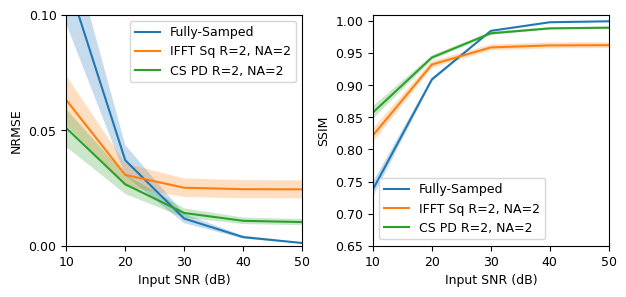

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(7,3)
fig.subplots_adjust(wspace=0.3)

#line1 = ax1.plot(noise_dB_zero,nrmse_ifft, '-')
line3 = ax1.plot(noise_dB_zero,nrmse_3dB, '-')
line4 = ax1.plot(noise_dB_zero,nrmse_ifft_sq, '-')
line2 = ax1.plot(noise_dB_zero,nrmse_cs, '-')
#ax1.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax1.set(ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
#ax1.set_xscale('log')
ax1.legend([ 'Fully-Samped', 'IFFT Sq R=2, NA=2', 'CS PD R=2, NA=2'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#fill1 = ax1.fill_between(noise_dB_zero,nrmse_ifft-nrmse_ifft_sd,nrmse_ifft+nrmse_ifft_sd,alpha=0.25)
fill3 = ax1.fill_between(noise_dB_zero,nrmse_3dB-nrmse_3dB_sd,nrmse_3dB+nrmse_3dB_sd,alpha=0.25)
fill4 = ax1.fill_between(noise_dB_zero,nrmse_ifft_sq-nrmse_ifft_sq_sd,nrmse_ifft_sq+nrmse_ifft_sq_sd,alpha=0.25)
fill2 = ax1.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)

step=10
#ax1.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax1.set_yticks([0,0.05,0.1])
ax1.set_xlim([10,50])
ax1.set_ylim([0,0.1])



#line1 = ax2.plot(noise_dB_zero,ssim_ifft, '-')
line3 = ax2.plot(noise_dB_zero,ssim_3dB, '-')
line4 = ax2.plot(noise_dB_zero,ssim_ifft_sq, '-')
line2 = ax2.plot(noise_dB_zero,ssim_cs, '-')
#ax2.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax2.set(ylabel='SSIM',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax2.legend([ 'Fully-Samped', 'IFFT Sq R=2, NA=2', 'CS PD R=2, NA=2'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
ax2.set_ylim(0.65,1.01)
ax2.set_xlim(10,50)

#fill1 = ax2.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)

fill3 = ax2.fill_between(noise_dB_zero,ssim_3dB-ssim_3dB_sd,ssim_3dB+ssim_3dB_sd,alpha=0.25)
fill4 = ax2.fill_between(noise_dB_zero,ssim_ifft_sq-ssim_ifft_sq_sd,ssim_ifft_sq+ssim_ifft_sq_sd,alpha=0.25)
fill2 = ax2.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)

step=10
#ax2.set_xticks(np.arange(noise_dB[0],noise_dB[-1]+step,step))
#ax2.set_yticks([0.8,0.9,1])

plt.show()

#fig.savefig('export_figs/fastmri_noise_curves.pdf',bbox_inches='tight',dpi=300)

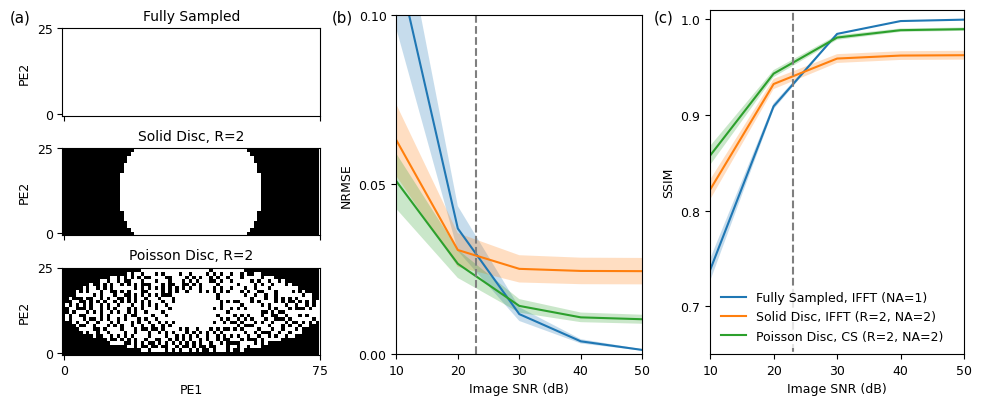

In [18]:
figsamp = plt.figure(figsize=(1.3*18.8/2.54,10/2.54),layout='compressed')
subfigs = figsamp.subfigures(1,3,wspace=0.01)

#subfigs[0] = fig
#subfigs[1] = fig
subfigs[0].suptitle('(a)',x=0.02,y=0.99)
axsLeft = subfigs[0].subplots(3,1,sharex=True)
mask1 = axsLeft[0].imshow(np.ones(mask.shape).T,clim=(0,1),origin='lower',cmap='gray')
mask2 = axsLeft[1].imshow(np.abs(mask_circ.T),clim=(0,1),origin='lower',cmap='gray')
mask3 = axsLeft[2].imshow(np.abs(mask.T),clim=(0,1),origin='lower',cmap='gray')
axsLeft[0].set_ylabel('PE2')
axsLeft[1].set_ylabel('PE2')
axsLeft[2].set_ylabel('PE2')
axsLeft[2].set_xlabel('PE1')
#axsLeft[1] = ax2
mask1.set_clim(0,1)

axsLeft[0].set_title('Fully Sampled',fontsize=10)
axsLeft[1].set_title('Solid Disc, R=2',fontsize=10)
axsLeft[2].set_title('Poisson Disc, R=2',fontsize=10)

for ax in axsLeft:
    ax.set_xticks([0,75])
    ax.set_yticks([0,25])


subfigs[1].suptitle('(b)',x=0.02,y=0.99)

axsCentre = subfigs[1].subplots(1,1)

#line1 = axsCentre.plot(noise_dB_zero,nrmse_ifft, '-')
line3 = axsCentre.plot(noise_dB_zero,nrmse_3dB, '-')
line4 = axsCentre.plot(noise_dB_zero,nrmse_ifft_sq, '-')
line2 = axsCentre.plot(noise_dB_zero,nrmse_cs, '-')
#axsCentre.set(title='Comparison of Reconstruction Methods, R='+str(R),
axsCentre.set(ylabel='NRMSE',
xlabel='Image SNR (dB)')

fill3 = axsCentre.fill_between(noise_dB_zero,nrmse_3dB-nrmse_3dB_sd,nrmse_3dB+nrmse_3dB_sd,alpha=0.25)
fill4 = axsCentre.fill_between(noise_dB_zero,nrmse_ifft_sq-nrmse_ifft_sq_sd,nrmse_ifft_sq+nrmse_ifft_sq_sd,alpha=0.25)
fill2 = axsCentre.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)

step=10
#axsCentre.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
axsCentre.set_yticks([0,0.05,0.1])
axsCentre.set_xlim([10,50])
axsCentre.set_ylim([0,0.1])
#axsCentre.set_aspect(400)
axsCentre.vlines(23,0,2,color='tab:gray',linestyle='--')

subfigs[2].suptitle('(c)',x=0.02,y=0.99)

axsRight = subfigs[2].subplots(1,1)

#line1 = axsRight.plot(noise_dB_zero,ssim_ifft, '-')
line3 = axsRight.plot(noise_dB_zero,ssim_3dB, '-')
line4 = axsRight.plot(noise_dB_zero,ssim_ifft_sq, '-')
line2 = axsRight.plot(noise_dB_zero,ssim_cs, '-')
#axsRight.set(title='Comparison of Reconstruction Methods, R='+str(R),
axsRight.set(ylabel='SSIM',
xlabel='Image SNR (dB)')
#axsCentre.set_xscale('log')
leg = axsRight.legend([ 'Fully Sampled, IFFT (NA=1)', 'Solid Disc, IFFT (R=2, NA=2)', 'Poisson Disc, CS (R=2, NA=2)'])
leg.get_frame().set_linewidth(0.0)
#axsCentre.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
axsRight.set_ylim(0.65,1.01)
axsRight.set_xlim(10,50)
axsRight.set_yticks([0.7,0.8,0.9,1.0])
axsRight.vlines(23,0,2,color='tab:gray',linestyle='--')

#fill1 = axsRight.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)

fill3 = axsRight.fill_between(noise_dB_zero,ssim_3dB-ssim_3dB_sd,ssim_3dB+ssim_3dB_sd,alpha=0.25)
fill4 = axsRight.fill_between(noise_dB_zero,ssim_ifft_sq-ssim_ifft_sq_sd,ssim_ifft_sq+ssim_ifft_sq_sd,alpha=0.25)
fill2 = axsRight.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)

#figsamp.savefig('export_figs/fastmri_sampling_snr.pdf',bbox_inches='tight',dpi=300)